In [2]:
import numpy as np

# Function to read ASCII raster file
def read_asc_file(file_path):
    # Read header information
    with open(file_path, 'r') as f:
        ncols = None
        nrows = None
        xllcorner = None
        yllcorner = None
        cellsize = None
        nodata_value = None

        for line in f:
            line = line.strip().split()
            if len(line) == 2:
                if line[0].lower() == 'ncols':
                    ncols = int(line[1])
                elif line[0].lower() == 'nrows':
                    nrows = int(line[1])
                elif line[0].lower() == 'xllcorner':
                    xllcorner = float(line[1])
                elif line[0].lower() == 'yllcorner':
                    yllcorner = float(line[1])
                elif line[0].lower() == 'cellsize':
                    cellsize = float(line[1])
                elif line[0].lower() == 'nodata_value':
                    nodata_value = float(line[1])
            else:
                break

    # Read data values
    data = np.genfromtxt(file_path, skip_header=6)

    return {
        'ncols': ncols,
        'nrows': nrows,
        'xllcorner': xllcorner,
        'yllcorner': yllcorner,
        'cellsize': cellsize,
        'nodata_value': nodata_value,
        'data': data
    }


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
import matplotlib.pyplot as plt

In [7]:
# Example usage
file_path = r""
data = read_asc_file(file_path)
print(data["data"])
print(data["data"].shape)

[[0.07637 0.07664 0.07703 ... 0.      0.      0.     ]
 [0.07644 0.07667 0.07695 ... 0.      0.      0.     ]
 [0.0764  0.07661 0.07688 ... 0.      0.      0.     ]
 ...
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]]
(716, 412)


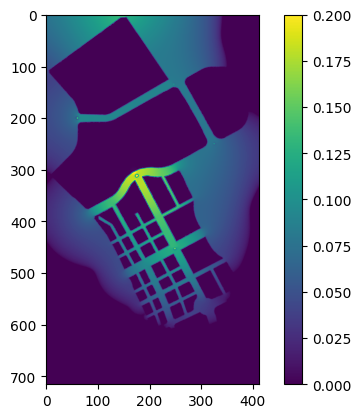

In [18]:
plt.figure()
plt.imshow(data["data"])
plt.clim(0.0,0.2)
plt.colorbar()

In [8]:
data_np = np.array(data["data"])

In [9]:
def avg_pool(arr):
    x, y = arr.shape
    new_x, new_y = x//2, y//2
    arr = np.mean(arr.reshape(new_x, 2, new_y, 2), axis=(1, 3))
    return arr

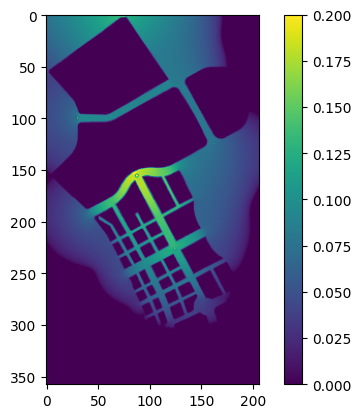

In [17]:
plt.imshow(avg_pool(data_np))
plt.clim(0.0,0.2)
plt.colorbar()

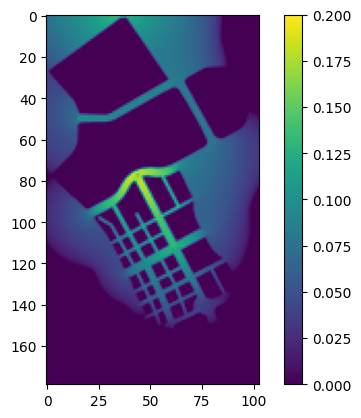

In [19]:
plt.imshow(avg_pool(avg_pool(data_np)))
plt.clim(0.0,0.2)
plt.colorbar()

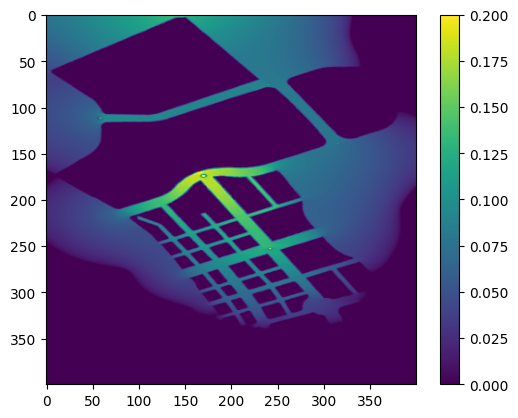

In [21]:
from skimage.transform import resize
plt.imshow(resize(data_np, (400, 400)))
plt.clim(0.0,0.2)
plt.colorbar()